# outline

Pytorch and Tensorflow are two of most popular neural network packages


Basically going through https://pytorch.org/tutorials/beginner/blitz

- do backpropagation, then do automatic differentiation 自动微分

- dynamic computation graphs: good for time series

- CPU, GPU


# import package

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # neural network module
import torch.nn.functional as F # import functiosn from neural network module, have ReLU function
import torch.optim as optim

# tensor

- Basic building blocks are tensors. 

    Tensors are higher-dimensional matrices. 

  A tensor $x \in \mathbb{R}^{d_1 \times d_2 \times \cdots \times d_k}$. 

  In this case $x$ is an order-$k$ tensor. 


- A matrix is an order $2$ tensor. 

  We have already seen tensors using numpy.

Tensor $x \in \mathbb{R}^{5 \times 2 \times 3}$

1st element of tensor $x$ is $x[0] \in \mathbb{R}^{2 \times 3}$

In [ ]:
x = np.random.randn(5,2,3)

In [ ]:
x[0], x[0].shape

(array([[ 1.00875662, -0.3334697 ,  0.24022493],
        [ 0.30561844, -0.39848815,  0.62735121]]),
 (2, 3))

## Connecting numpy array and tensor

convert numpy array to tensor

- `torch.tensor(x)` create a tensor object copy of x **without** a shared memory

    like `y = x.copy()`

- `torch.from_numpy(x)` create a tensor object copy of x **with** a shared memory

    like `y = x`

convert tensor to numpy array

- `tensor.numpy()` convert tensor object to numpy array with shared memory

In [ ]:
x = np.random.randn(5,2,3) 
x_tensor1 = torch.tensor(x)   # create a tensor object copy of x without shared memory
x_tensor2 = torch.from_numpy(x)  # create a tensor object copy of x with shared memory
x_tensor1[0,0,0] = 2.   # assignment
print(x_tensor1[0,0,0] == x[0,0,0]) # x is not changed
x_tensor2[0,0,0] = 2   # assignment
print(x_tensor2[0,0,0] == x[0,0,0]) # x is changed
y = x_tensor1.numpy()
y[0,0,0] = 3 # change numpy array
print(y[0,0,0] == x_tensor1[0,0,0]) # tensor also changed

tensor(False)
tensor(True)
tensor(True)


# create a tensor

In [ ]:
x = torch.randn((5,2,4)) # create a random tensor filled with random numbers from a normal distribution N(0, 1)
y = torch.ones_like(x) # create a tensor of entries all 1 the same shape as x 5*2*4
x.shape, y.shape # shape  torch.Size([5, 2, 4])

(torch.Size([5, 2, 4]), torch.Size([5, 2, 4]))

In [ ]:
x[:,0,1] # slicing, all first direction, second direction choose first (row), third direction choose second (column)

tensor([ 1.1272,  0.3337, -1.6857, -0.3709, -0.2804])

# GPU

## set up a GPU

>> Edit >> Notebook setting >> GPU >> Save

need to rerun previous code

set back CPU

>> Edit >> Notebook setting >> None >> Save

## send data in CPU to GPU

cuda is a driver for using GPU

`x.to('cuda')` send data in CPU memory to GPU memory

GPU has a limited memory, sometimes need to move data out of GPU for moving new data into GPU

In [ ]:
if torch.cuda.is_available():
  x = x.to('cuda') # send data in CPU memory to GPU memory
x # specifically tell me data x is in GPU device='cuda:0'

tensor([[[ 0.2153, -0.7024,  0.3652],
         [-0.6937, -1.0595,  0.5903]],

        [[ 0.6977, -1.0401, -0.4598],
         [-0.9849, -1.3888, -0.3569]],

        [[ 0.0861,  0.6001, -0.3175],
         [ 1.7425,  0.6018, -0.0311]],

        [[ 0.1357,  0.7856,  0.0649],
         [-0.1118, -0.4513,  0.1283]],

        [[ 0.2394,  1.0172, -0.2181],
         [ 0.2005, -1.0823,  0.6162]]], device='cuda:0', dtype=torch.float64)

In [ ]:
y_1 = torch.ones((5,2,3))
y_1+x

RuntimeError: ignored

RuntimeError bc `x` is in GPU, while `y_1` is in CPU, not in same world

to avoid error, create a y in GPU:

- `y=torch.ones_like(x)`

- `y=torch.ones((), device='cuda)`

In [ ]:
y_2 = torch.ones_like(x)
y_2+x # no RuntimeError

tensor([[[ 2.1744,  1.2092,  0.1838],
         [ 1.3507, -0.1576,  0.8788]],

        [[ 1.0154,  1.9069,  1.7529],
         [ 2.2929, -0.2639,  1.3135]],

        [[ 0.5416,  0.4768, -1.0241],
         [ 1.2094, -0.2649,  2.5921]],

        [[-0.7464,  0.3123,  1.7185],
         [ 0.0928,  1.8751,  0.9004]],

        [[ 0.8114, -0.3790,  1.8081],
         [ 2.5928,  0.7554, -0.0628]]], device='cuda:0', dtype=torch.float64)

In [ ]:
y_3 = torch.ones((5,2,3),device='cuda')
y_3+x # no RuntimeError

tensor([[[ 2.1744,  1.2092,  0.1838],
         [ 1.3507, -0.1576,  0.8788]],

        [[ 1.0154,  1.9069,  1.7529],
         [ 2.2929, -0.2639,  1.3135]],

        [[ 0.5416,  0.4768, -1.0241],
         [ 1.2094, -0.2649,  2.5921]],

        [[-0.7464,  0.3123,  1.7185],
         [ 0.0928,  1.8751,  0.9004]],

        [[ 0.8114, -0.3790,  1.8081],
         [ 2.5928,  0.7554, -0.0628]]], device='cuda:0', dtype=torch.float64)

## back to CPU

In [ ]:
x = x.to('cpu')
x.device

device(type='cpu')

# Automatic differentiation 自动微分

We ask `pytorch` to keep track of the gradient of $f$ for $x$. 

$$
f = \sum_{i,j} (x_{ij} + y_{ij})x_{ij} = \sum_{i,j} z_{ij} x_{ij} 
$$

We know that gradient of $f$ w.r.t $x$ will be
$$
\nabla_x f = 2 x + y
$$

gradient of $f$ w.r.t $f$ will be 

$$
\nabla_f f = 1
$$

## calculate gradient of f w.r.t itself (root tensor)

In [ ]:
x = torch.rand((2,3), requires_grad=True)
y = torch.ones_like(x)
z = x+y
f = torch.sum(z*x) # f = elementwise z*x, then sum all entries up
f.retain_grad()    # important: keep gradient of f w.r.t f; otherwise Warning
f.backward() # calculate gradient of f 
f.grad

tensor(1.)

In [ ]:
x.requires_grad, y.requires_grad, z.requires_grad, f.requires_grad

(True, False, True, True)

In [ ]:
z, f # both z and f have a gradient function <AddBackward0> and <SumBackward0>

(tensor([[1.2777, 1.4239, 1.8767],
         [1.3738, 1.6138, 1.1432]], grad_fn=<AddBackward0>),
 tensor(4.2716, grad_fn=<SumBackward0>))

## calculate gradient of f w.r.t x (leaf tensor)

In [ ]:
x = torch.rand((2,3), requires_grad=True)
y = torch.ones_like(x)
z = x+y
f = torch.sum(z*x) # f = elementwise z*x, then sum all entries up
f.backward() # calculate gradient of f 

x.grad # the gradient of f with respect to x

tensor([[1.1760, 1.6118, 2.5094],
        [2.5039, 1.4299, 2.2100]])

In [ ]:
# check if the gradient is correct
2*x+y # same as x.grad

tensor([[1.1760, 1.6118, 2.5094],
        [2.5039, 1.4299, 2.2100]], grad_fn=<AddBackward0>)

# Dynamic computation graphs

- Example 1: $x = 0.4, y = x^2$

$$
\nabla_x f = 2x
$$

In [ ]:
def func(x):
  """
  if 0.2 < x < 2,  calculate x^2 untill x<=0.2 or x>=2
  """
  while 0.2 < x < 2:
    x = x * x
  return x

x = torch.tensor(.4, requires_grad=True)
f = func(x)
f.backward()
x.grad, 2 * x 

(tensor(0.8000), tensor(0.8000, grad_fn=<MulBackward0>))

- Example 2: $x = 0.7, y = x^8$

$$
\nabla_x f = 8x^7
$$

In [ ]:
def func(x):
  """
  if 0.2 < x < 2,  calculate x^2 untill x<=0.2 or x>=2
  """
  while 0.2 < x < 2:
    x = x * x
  return x

x = torch.tensor(.7, requires_grad=True)
f = func(x)
f.backward()
x.grad, 8 * x ** 7

(tensor(0.6588), tensor(0.6588, grad_fn=<MulBackward0>))

## all the gradients stored in memory will be released after complete backpropogation

In [ ]:
def func(x):
  """
  if 0.2 < x < 2,  calculate x^2 untill x<=0.2 or x>=2
  """
  while 0.2 < x < 2:
    x = x * x
  return x

x = torch.tensor(.7, requires_grad=True)
f = func(x)
f.backward()
x.grad, 8 * x ** 7

f.backward()  # RuntimeError bc saved gradients are already freed

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

`pytorch` does not retain the computation graph after the backward propagation is performed 

unless you explicitly ask it to retain the graph. 

it calculate a graident per iteration and store in memory

it don't know to combine power so could only calculate one gradient at last,

but once you call `backward()`, pytorch will release all the gradients stored in memory

that's good, coz GPU don't have much memory

This operation is useful for doing higher-order derivatives, 

so if you call `backward` again, you get runtime error


`RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed.` 

Specify `retain_graph=True` when calling `.backward()` or `autograd.grad()` the first time.

In [ ]:
def func(x):
  """
  if 0.2 < x < 2,  calculate x^2 untill x<=0.2 or x>=2
  """
  while 0.2 < x < 2:
    x = x * x
  return x

x = torch.tensor(.7, requires_grad=True)
f = func(x)
f.backward(retain_graph=True)
x.grad, 8 * x ** 7

f.backward()  # no error

# Define and train a neural network

`nn.Linear()` 

- create all the underlying the param matrix $W$ and bias vector $b$, 

  `self.fc1` contains $z_2 = W_1x+b_1$

- make all dimensions work

- initialize of entry with random numbers

  `F.relu(self.fc1)` do $ReLU(z_2)$

## import neural network module

## define neural net class

In [2]:
class Net(nn.Module):
  """
  a class inherit from nn.Module
  """

  def __init__(self):
    """
    keep track of params in neural net
    """
    super(Net, self).__init__()

    # create 4 layers: input->hidden layer->hidden layer->output
    self.fc1 = nn.Linear(1,40) # input->hidden layer: linear function, dimension go from R^1 to R^40
    self.fc2 = nn.Linear(40,40) # hidden layer->hidden layer: linear function, dimension go from R^40 to R^40
    self.o = nn.Linear(40,1) # hidden layer->output: linear function, dimension go from R^40 to R^1

  def forward(self, x):
    """
    forward pass
    """
    x = F.relu(self.fc1(x)) # apply pointwise ReLU activation
    x = F.relu(self.fc2(x))
    x = self.o(x) 
    return x

net = Net() # create a new Net object called net, automatically run __init__ method
print(net)

Net(
  (fc1): Linear(in_features=1, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (o): Linear(in_features=40, out_features=1, bias=True)
)


## training set should be a batched tensor

input should be a batch tensor form, all data taken in once, don't need a for-loop

In [3]:
x=torch.arange(-1,1,0.01).reshape((-1,1))
x.shape

torch.Size([200, 1])

sample dataset: 200 * 1

sample dataset of MNIST: 200 * 28 * 28

sample data set of colored image: 200 * 3 * 28 * 28, 3 comes from RGB

sample data set of astronomy: 200 * 100 * 28 * 28, 100 comes from channels (spectrums)

## disabling gradient calculation for inference

In [4]:
# training
x=torch.randn((1,1)) 
y= torch.sum(net(x))
y.backward()

#  testing
# with torch.no_grad():  # disabling gradient calculation for inference
#   y=net(x) 
#   y.requires_grad 

## params and gradients

- see params use `net.parameters()`

  all the params has `requires_grad=True` and are all leaf nodes,

  so when apply net(x), pytorch keep track of all gradeint computation,

- we can see gradient use `net.parameters().grad`

In [5]:
# print params and gradient 
# first layer: W1,b1, second layer: W2,b2, third layer: W3,b3
names = ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
for name, param in zip(names, net.parameters()):
  print(name, param.shape, param.grad.shape)

W1 torch.Size([40, 1]) torch.Size([40, 1])
b1 torch.Size([40]) torch.Size([40])
W2 torch.Size([40, 40]) torch.Size([40, 40])
b2 torch.Size([40]) torch.Size([40])
W3 torch.Size([1, 40]) torch.Size([1, 40])
b3 torch.Size([1]) torch.Size([1])


# training

use `torch.optim.Adam()`  adaptive gradient with momentum

## batch gradient descent

Text(0.5, 1.0, 'Batch gradient descent')

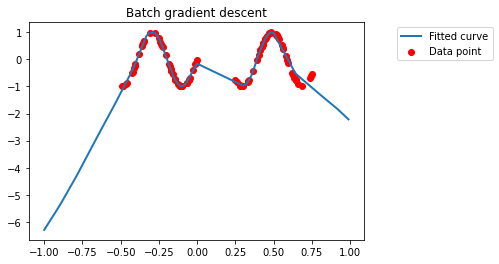

In [23]:
xtrain = torch.cat((torch.rand((50,1))*0.5-.5, torch.rand((50,1))*0.5+0.25)) # [100, 1]
ytrain = torch.sin(16*xtrain) # [100, 1]

net=Net()
criterion = nn.MSELoss()  # mean square error loss
optimizer = optim.Adam(net.parameters(), lr=0.00002)

# training, do optimization for 20,000 iterations for gradient update
for j in range(40000):

  optimizer.zero_grad() # update with new version of gradient

  yhat = net(xtrain) # predicted label

  loss = criterion(yhat, ytrain) # loss function   torch.norm(yhat-ytrain)**2/yhat.shape[0]

  loss.backward() # calculate gradient of loss

  optimizer.step() # step in the gradeint direction using Adam rules

# training result: good
x=torch.arange(-1,1,0.01).reshape((-1,1))
plt.plot(x[:,0],net(x).detach().numpy()[:,0],linewidth=2, label='Fitted curve')
plt.scatter(xtrain.numpy()[:,0], ytrain.numpy()[:,0],c='red', label='Data point')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.title("Batch gradient descent")

## mini-batch gradient descent

batch size depends on sample size, memory, how to do optimization

### Dataloader


In [16]:
# create a dataloader, chunks data into 4 batches
dataset = list(zip(xtrain,ytrain))
data_train = torch.utils.data.DataLoader(dataset, batch_size=4)

In [17]:
# print first batch
list(data_train)[0]

[tensor([[-0.2665],
         [-0.3706],
         [-0.1819],
         [-0.1020]]), tensor([[ 0.9011],
         [ 0.3460],
         [-0.2296],
         [-0.9981]])]

### training

Text(0.5, 1.0, 'Mini-batch gradient descent')

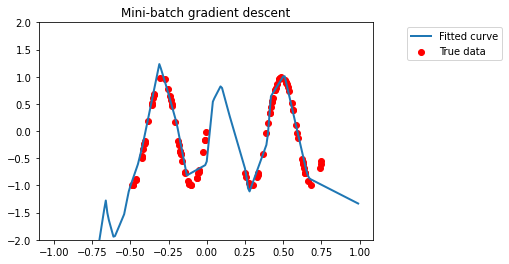

In [25]:
net=Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00002)

for epoch in range(4000): # pass data for 4000 times
  for x_1,y_1 in data_train: # pass 4 batches of data
    yhat = net(x_1)
    loss = criterion(yhat,y_1)
    loss.backward()
    optimizer.step()

# training result different from full gradient descent
x=torch.arange(-1,1,0.01).reshape((-1,1))
plt.plot(x[:,0],net(x).detach().numpy()[:,0],linewidth=2, label='Fitted curve')
plt.scatter(xtrain.numpy()[:,0],ytrain.numpy()[:,0],c='red', label='True data')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.ylim([-2,2])
plt.title("Mini-batch gradient descent")

## t-SNE

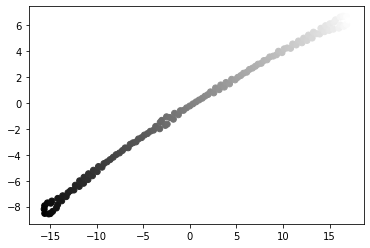

In [26]:
from sklearn.manifold import TSNE

x = torch.arange(-0.5,0.75,0.01)[:,None]  # [125, 1]

lastlayer = F.relu(net.fc2(F.relu(net.fc1(x))))  # [125, 40]

alphahat = TSNE(n_components=2,perplexity=20).fit_transform(lastlayer.detach().numpy())  # (125, 2)

plt.scatter(alphahat[:,0],alphahat[:,1],c=np.linspace(0,1,alphahat.shape[0]),cmap=plt.cm.gray)

# Computer vision
Image classification

- Basically following https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

- and this one https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [28]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

## load data

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 4
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,pin_memory=True)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [44]:
# data and label of first image in training set
trainset[0][0][0].shape, trainset[0][1]

(torch.Size([28, 28]), 5)

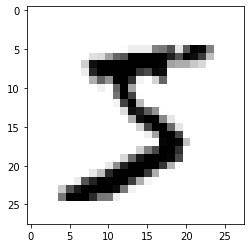

In [34]:
# print first image in training set
plt.imshow(trainset[0][0][0],cmap=plt.cm.gray_r)

## architecture

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##conv1: 1x28x28 -> 10x24x24
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        ##will get max pooled by 2: 10x24x24 -> 10x12x12
        ##conv2: 10x12x12 -> 20x8x8
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) ##output is 20 channels
        ##will get max pooled by 2: 20x8x8 -> 20x4x4
        ##fully connected 1: 320 -> 50 
        self.fc1 = nn.Linear(320, 50)
        ##fully connected 2: 50 -> 10 (need to estimate 10 different labels)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320) ##flatten the image
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [46]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
device

device(type='cpu')

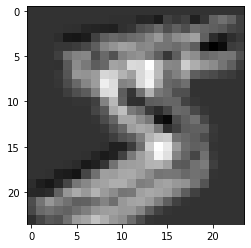

In [48]:
plt.imshow(net.conv1(trainset[0][0][None,:,:,:])[0][0].detach(),cmap=plt.cm.gray_r)

In [49]:
net.conv1(trainset[0][0][None,:,:,:])[0][0].detach().shape

torch.Size([24, 24])

In [50]:
F.max_pool2d(net.conv1(trainset[0][0][None,:,:,:]),2).shape

torch.Size([1, 10, 12, 12])

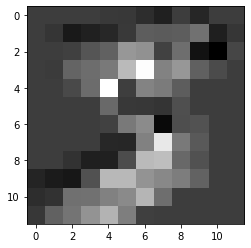

In [51]:
plt.imshow(F.max_pool2d(net.conv1(trainset[0][0][None,:,:,:]),2).detach()[0,0],cmap=plt.cm.gray_r)

## training

In [52]:
net.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
F.max_pool2d(net.conv1(trainset[0][0][None,:,:,:].to(device)),2).shape

torch.Size([1, 10, 12, 12])

In [53]:
for params in net.parameters():
  print(params.is_cuda)

False
False
False
False
False
False
False
False


In [58]:
net.to(device)
criterion = nn.CrossEntropyLoss()
# criterion(torch.tensor([1.,0.])[None,:], torch.tensor([0]))
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 0.368
[1,  4000] loss: 0.121
[1,  6000] loss: 0.098
[1,  8000] loss: 0.086
[1, 10000] loss: 0.079
[1, 12000] loss: 0.079
[1, 14000] loss: 0.068
[2,  2000] loss: 0.053
[2,  4000] loss: 0.054
[2,  6000] loss: 0.056
[2,  8000] loss: 0.054
[2, 10000] loss: 0.055
[2, 12000] loss: 0.056
[2, 14000] loss: 0.054


## test

In [ ]:
correct = 0
total = 0
# no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) #will always be adding 4
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class 0     is: 98.1 %
Accuracy for class 1     is: 99.2 %
Accuracy for class 2     is: 98.7 %
Accuracy for class 3     is: 98.5 %
Accuracy for class 4     is: 96.1 %
Accuracy for class 5     is: 98.8 %
Accuracy for class 6     is: 99.6 %
Accuracy for class 7     is: 98.7 %
Accuracy for class 8     is: 99.0 %
Accuracy for class 9     is: 98.4 %


# Visualize trained filters

In [ ]:
net.conv1.bias.shape

torch.Size([10])

In [ ]:
net.conv1.weight.shape

torch.Size([10, 1, 5, 5])

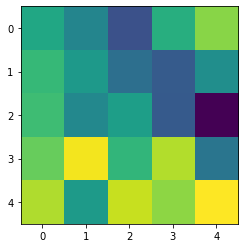

In [59]:
plt.imshow(net.conv1.weight[0][0].to('cpu').detach()) 

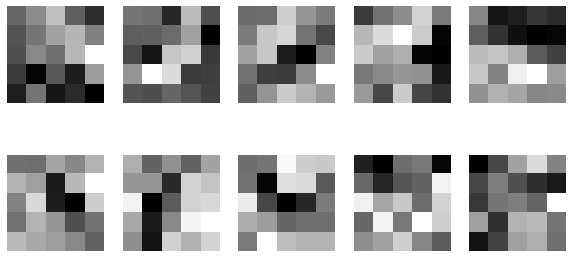

In [60]:
f,a = plt.subplots(2,5,figsize=(10,5))
for j in range(2):
    for k in range(5):
        a[j,k].axis('off')
        a[j,k].imshow(net.conv1.weight[5*j+k][0].to('cpu').detach(),cmap=plt.cm.gray.reversed())


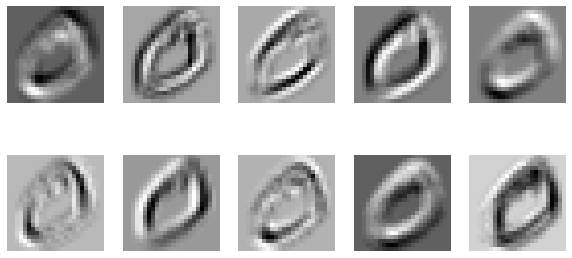

In [61]:
f,a = plt.subplots(2,5,figsize=(10,5))
for j in range(2):
    for k in range(5):
        a[j,k].axis('off')
        a[j,k].imshow(net.conv1(trainset[1][0][None,:,:,:].to(device))[0][5*j+k].detach().to('cpu'),cmap=plt.cm.gray_r)

# What do different neurons capture
(check out these notes also https://cs231n.github.io/understanding-cnn/)

In [ ]:
def neuronactivation(x,model):
  x = F.relu(F.max_pool2d(model.conv1(x), 2))
  x = F.relu(F.max_pool2d(model.conv2(x), 2))
  return x.view(-1, 320) ##flatten the image
activations = []
with torch.no_grad():
    for data in testloader:
        images = data[0].to(device)
        activations.append((data[0].numpy(),data[1].numpy(),neuronactivation(images,net).to('cpu').numpy()))
activations[0][2].shape

See how different neurons behave

In [ ]:
neuronpick=200
firstneuron = [(j[0][k],j[1][k],j[2][k,neuronpick]) for j in activations for k in range(4)]
firstneuron[0][2]
A = list(zip(*firstneuron))
testims = np.array((A[0]))
act = np.array(A[2])
actargsort = np.argsort(-act)
act[actargsort[0]]

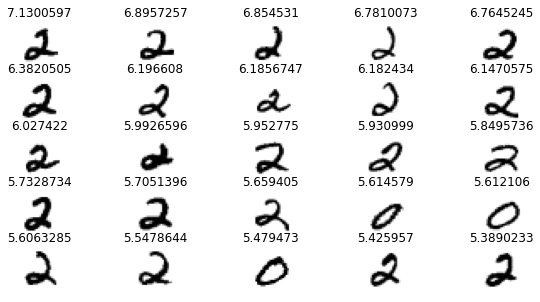

In [ ]:
skip=1
f,a = plt.subplots(5,5,figsize=(10,5))
for j in range(5):
    for k in range(5):
        a[j,k].axis('off')
        a[j,k].imshow(testims[actargsort[skip*(5*j+k)]][0],cmap=plt.cm.gray_r)
        a[j,k].set_title(act[actargsort[skip*(5*j+k)]])
